# IMDb Movie Review Dataset — Sentiment Analysis

In [1]:
# importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
#from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics import classification_report
import tabulate

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Embedding, Bidirectional, Dropout

In [2]:
nltk.download('stopwords')
stopwords = stopwords.words('english')
stopwords.append('br')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# loading the datasets
train = pd.read_csv('Train.csv')
valid = pd.read_csv('Valid.csv')
test = pd.read_csv('Test.csv')

In [7]:
train.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [8]:
# function to preprocess the review text
def preprocess(text):
    text = re.sub(r'[^\w\s]', '', text)                                           # retaining only alphanumerics and spaces (removing punctuation)
    text = re.sub(r'http\S+', '', text)                                           # removing URLs
    text = text.lower()                                                           # casefolding (lowercase)
    text = [w for w in text.split(' ') if w not in stopwords]                     # removing stopwords
    #text = [str(TextBlob(i).correct()) for i in text]                            # correcting spellings
    text = " ".join(text)
    return text

In [9]:
# preprocessing all the data
train['text'] = train.text.apply(lambda x: preprocess(x))
valid['text'] = valid.text.apply(lambda x: preprocess(x))
test['text']= test.text.apply(lambda x: preprocess(x))

train.head()

,text,label
0,grew b 1965 watching loving thunderbirds mates...,0
1,put movie dvd player sat coke chips expectatio...,0
2,people know particular time past like feel nee...,0
3,even though great interest biblical movies bor...,0
4,im die hard dads army fan nothing ever change ...,1


In [10]:
# lemmatization
train['text'] = train.text.apply(lambda x: WordNetLemmatizer().lemmatize(x))
valid['text'] = valid.text.apply(lambda x: WordNetLemmatizer().lemmatize(x))
test['text'] = test.text.apply(lambda x: WordNetLemmatizer().lemmatize(x))

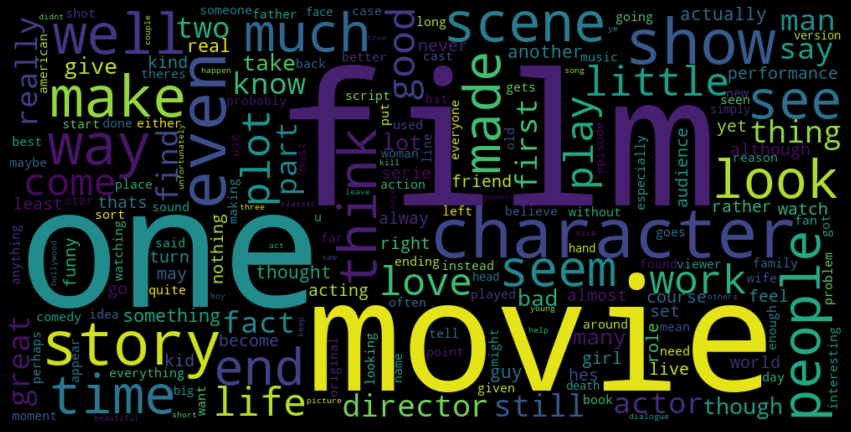

In [11]:
# visualising the most frequent words

text = " ".join(i for i in train.text)
stop_words = ["br"] + list(STOPWORDS)
wordcloud = WordCloud(stopwords=stop_words, width=1000, height=500).generate(text)
plt.figure(figsize=(15,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [12]:
# bigram frequencies
words = train['text'].tolist()

tokenized = [word_tokenize(i) for i in words]
flat_list = [num for sublist in tokenized for num in sublist]

bigram_df = pd.DataFrame(pd.Series(nltk.ngrams(flat_list, 2)).value_counts()).rename_axis('bigram').reset_index('bigram')
bigram_df.columns = ['bigram', 'count']
bigram_df['bigram'] = bigram_df['bigram'].astype("string")
bigram_df.head(10)

,bigram,count
0,"('ever', 'seen')",2033
1,"('ive', 'seen')",1783
2,"('special', 'effects')",1715
3,"('can', 'not')",1657
4,"('dont', 'know')",1633
5,"('even', 'though')",1560
6,"('one', 'best')",1485
7,"('looks', 'like')",1319
8,"('much', 'better')",1143
9,"('see', 'movie')",1139


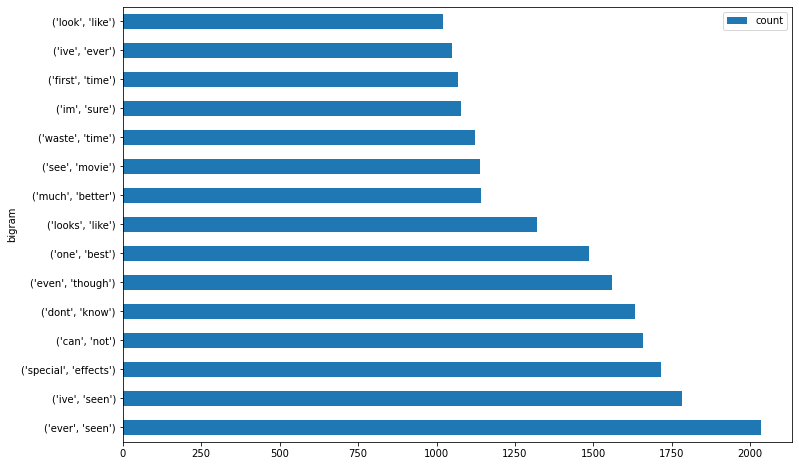

In [13]:
#plt.figure(figsize=(15,20))
bigram_df.head(15).plot(kind='barh', x='bigram', y='count', figsize=(12,8));
#plt.show()

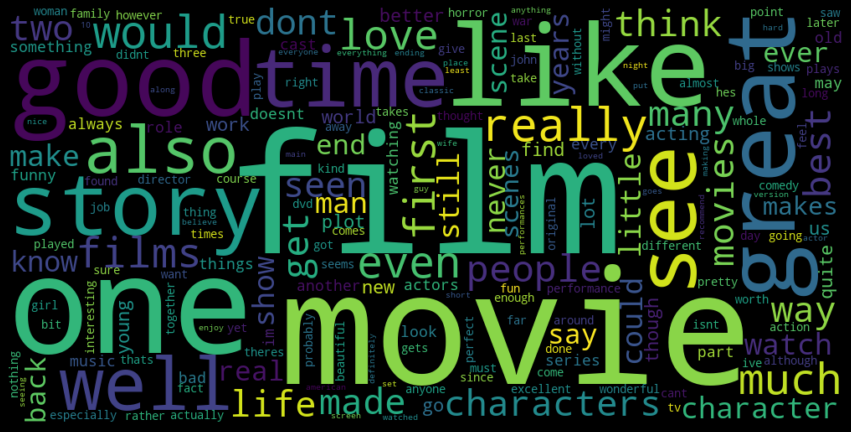

In [14]:
# visualizing words that convey positive sentiments
pos_freq = FreqDist(' '.join(train[train['label'] == 1].text).split(' '))
wordcloud = WordCloud(stopwords=stop_words, width=1000, height=500).generate_from_frequencies(pos_freq)
plt.figure(figsize=(15,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

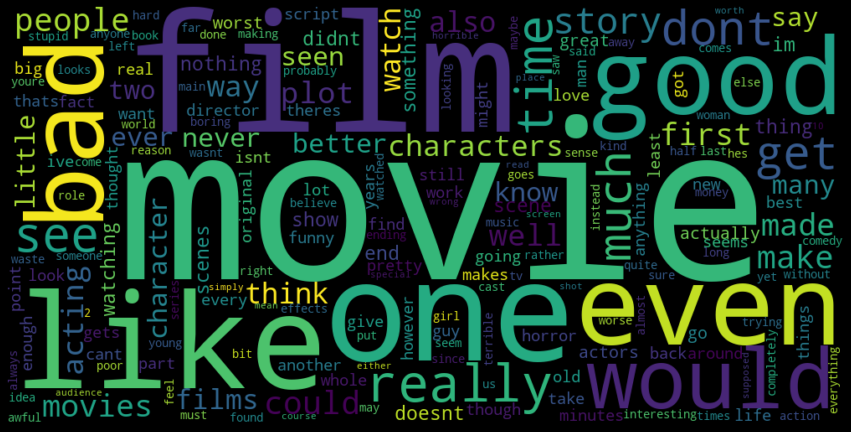

In [15]:
# visualizing words that convey negative sentiments
neg_freq = FreqDist(' '.join(train[train['label'] == 0].text).split(' '))
wordcloud = WordCloud(stopwords=stop_words, width=1000, height=500).generate_from_frequencies(frequencies=neg_freq)
plt.figure(figsize=(15,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [16]:
# splitting into x and y sets
train_x = train['text']
valid_x = valid['text']
test_x = test['text']

train_y = train['label']
valid_y = valid['label']
test_y = test['label']

In [17]:
# tokenization
tokenizer = Tokenizer()

# preparing vocabulary
tokenizer.fit_on_texts(train_x)

# converting text into integer sequences
train_x = tokenizer.texts_to_sequences(train_x)
valid_x = tokenizer.texts_to_sequences(valid_x)
test_x = tokenizer.texts_to_sequences(test_x)

# padding to prepare sequences of same length
train_x=pad_sequences(train_x,maxlen=120)
valid_x=pad_sequences(valid_x,maxlen=120)
test_x=pad_sequences(test_x,maxlen=120)

In [18]:
# checking size of vocabulary
size_of_vocabulary = len(tokenizer.word_index)+1
print(size_of_vocabulary)

160302


In [19]:
# building LSTM model
model1 = Sequential()

# embedding layer
model1.add(Embedding(size_of_vocabulary, 128, input_length=120))

# 14 LSTM layers
model1.add(LSTM(14, return_sequences=True, dropout=0.2))

# final LSTM layer
model1.add(LSTM(1, return_sequences=False, dropout=0.2))

model1.add(Dropout(0.05))

# output layer
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 128)          20518656  
                                                                 
 lstm (LSTM)                 (None, 120, 14)           8008      
                                                                 
 lstm_1 (LSTM)               (None, 1)                 64        
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 20,526,730
Trainable params: 20,526,730
Non-trainable params: 0
_________________________________________________________________


In [20]:
# fitting the model
history1 = model1.fit(train_x, train_y, batch_size=128, epochs=10, validation_data=(valid_x, valid_y), verbose=1)

Epoch 1/10
313/313 [==============================] - 124s 383ms/step - loss: 0.5169 - accuracy: 0.7985 - val_loss: 0.4258 - val_accuracy: 0.8662
Epoch 2/10
313/313 [==============================] - 117s 373ms/step - loss: 0.3406 - accuracy: 0.9025 - val_loss: 0.3698 - val_accuracy: 0.8742
Epoch 3/10
313/313 [==============================] - 119s 379ms/step - loss: 0.2589 - accuracy: 0.9319 - val_loss: 0.3563 - val_accuracy: 0.8744
Epoch 4/10
313/313 [==============================] - 115s 369ms/step - loss: 0.2047 - accuracy: 0.9467 - val_loss: 0.3594 - val_accuracy: 0.8724
Epoch 5/10
313/313 [==============================] - 120s 383ms/step - loss: 0.1720 - accuracy: 0.9530 - val_loss: 0.3351 - val_accuracy: 0.8810
Epoch 6/10
313/313 [==============================] - 117s 376ms/step - loss: 0.1501 - accuracy: 0.9567 - val_loss: 0.3396 - val_accuracy: 0.8768
Epoch 7/10
313/313 [==============================] - 119s 381ms/step - loss: 0.1325 - accuracy: 0.9593 - val_loss: 0.3437 -

In [21]:
# evaluating on test data
loss1, acc1 = model1.evaluate(test_x, test_y)

157/157 [==============================] - 4s 22ms/step - loss: 0.3758 - accuracy: 0.8762


In [22]:
# building bidRNN model
model2 = Sequential()

# embedding layer
model2.add(Embedding(size_of_vocabulary, 128, input_length=120))

# bidirectional simplernn layers
model2.add(Bidirectional(SimpleRNN(20)))

# softmax output layer for probability distribution
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 128)          20518656  
                                                                 
 bidirectional (Bidirectiona  (None, 40)               5960      
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
Total params: 20,524,657
Trainable params: 20,524,657
Non-trainable params: 0
_________________________________________________________________


In [23]:
# fitting the model
history2 = model2.fit(train_x, train_y, batch_size=128, epochs=10, validation_data=(valid_x, valid_y), verbose=1)

Epoch 1/10
313/313 [==============================] - 109s 342ms/step - loss: 0.4757 - accuracy: 0.7743 - val_loss: 0.3749 - val_accuracy: 0.8474
Epoch 2/10
313/313 [==============================] - 107s 342ms/step - loss: 0.2099 - accuracy: 0.9220 - val_loss: 0.3351 - val_accuracy: 0.8636
Epoch 3/10
313/313 [==============================] - 106s 338ms/step - loss: 0.0538 - accuracy: 0.9848 - val_loss: 0.3735 - val_accuracy: 0.8678
Epoch 4/10
313/313 [==============================] - 111s 355ms/step - loss: 0.0111 - accuracy: 0.9986 - val_loss: 0.4274 - val_accuracy: 0.8644
Epoch 5/10
313/313 [==============================] - 108s 346ms/step - loss: 0.0030 - accuracy: 0.9998 - val_loss: 0.4578 - val_accuracy: 0.8540
Epoch 6/10
313/313 [==============================] - 108s 344ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.4929 - val_accuracy: 0.8616
Epoch 7/10
313/313 [==============================] - 106s 338ms/step - loss: 6.9714e-04 - accuracy: 1.0000 - val_loss: 0.51

In [24]:
# evaluating on test data
loss2, acc2 = model2.evaluate(test_x, test_y)

157/157 [==============================] - 2s 15ms/step - loss: 0.5671 - accuracy: 0.8616


In [25]:
# precision, recall, f1-score of LSTM
pred_1 = model1.predict(test_x)
pred_1[pred_1>0.5] = 1
pred_1[pred_1<=0.5] = 0
print(classification_report(test_y, pred_1))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      2495
           1       0.87      0.88      0.88      2505

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



In [26]:
# precision, recall, f1-score of BidRNN
pred_2 = model2.predict(test_x)
pred_2[pred_2>0.5] = 1
pred_2[pred_2<=0.5] = 0
print(classification_report(test_y, pred_2))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      2495
           1       0.87      0.85      0.86      2505

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



In [27]:
# comparing both the models
table = [['Model', 'Loss', 'Accuracy'],
         ['LSTM', loss1, acc1],
         ['BidRNN', loss2, acc2]]

print(tabulate.tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═════════╤══════════╤════════════╕
│ Model   │     Loss │   Accuracy │
╞═════════╪══════════╪════════════╡
│ LSTM    │ 0.375839 │     0.8762 │
├─────────┼──────────┼────────────┤
│ BidRNN  │ 0.56707  │     0.8616 │
╘═════════╧══════════╧════════════╛


The LSTM model performs better than simple RNN, with lower loss, higher f1-scores, and overall higher accuracy. This is because it can take previous context into account by maintaining information in memory cells. Its accuracy can be improved further by using Bidirectional LSTM layers.

# Using a different test set

In [28]:
# importing my own test set
test2 = pd.read_csv('Test2.csv')
test2.head()

,text,label
0,You only get to watch this for the first time ...,1
1,Some movies run off the rails. This one is lik...,0
2,This film manages to redeem Hollywood in the e...,1
3,It is no wonder that the film has such a high ...,1
4,The Snowman is like if aliens studied humanity...,0


In [29]:
# preprocessing, lemmatization, tokenization
test2['text'] = test2.text.apply(lambda x: preprocess(x))
test2['text'] = test2.text.apply(lambda x: WordNetLemmatizer().lemmatize(x))
test2_x = test2['text']
test2_y = test2['label']
test2_x = tokenizer.texts_to_sequences(test2_x)
test2_x = pad_sequences(test2_x, maxlen=120)

In [30]:
# evaluating the LSTM model on this test data
testloss1, testacc1 = model1.evaluate(test2_x, test2_y)

1/1 [==============================] - 0s 36ms/step - loss: 0.4010 - accuracy: 0.9000


In [34]:
# precision, recall, f1-score of BidRNN
pred_test1 = model1.predict(test2_x)
pred_test1[pred_test1>0.5] = 1
pred_test1[pred_test1<=0.5] = 0
print(classification_report(test2_y, pred_test1))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.83      1.00      0.91         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



In [31]:
# evaluating the BidRNN model on this test data
testloss2, testacc2 = model2.evaluate(test2_x, test2_y)

1/1 [==============================] - 0s 36ms/step - loss: 1.4059 - accuracy: 0.7000


In [35]:
# precision, recall, f1-score of BidRNN
pred_test2 = model2.predict(test2_x)
pred_test2[pred_test2>0.5] = 1
pred_test2[pred_test2<=0.5] = 0
print(classification_report(test2_y, pred_test2))

              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.62      1.00      0.77         5

    accuracy                           0.70        10
   macro avg       0.81      0.70      0.67        10
weighted avg       0.81      0.70      0.67        10



In [32]:
# comparing both the models
table = [['Model', 'Loss', 'Accuracy'],
         ['LSTM', testloss1, testacc1],
         ['BidRNN', testloss2, testacc2]]

print(tabulate.tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═════════╤══════════╤════════════╕
│ Model   │     Loss │   Accuracy │
╞═════════╪══════════╪════════════╡
│ LSTM    │ 0.401044 │        0.9 │
├─────────┼──────────┼────────────┤
│ BidRNN  │ 1.40592  │        0.7 │
╘═════════╧══════════╧════════════╛


The LSTM model generalizes best, with 90% accuracy, lower loss, and higher f1-scores than BidRNN (70% accuracy).